# Create FLM example files

Create example bed files for FLM exon 6 to visualise in IGV

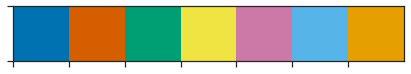

In [1]:
import sys
import os
import re
from glob import glob
from collections import Counter, defaultdict
import itertools as it
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
def parse_exons(record):
    start = int(record[1])
    end = int(record[2])
    exstarts = np.fromstring(record[11], sep=',', dtype=int) + start
    exends = exstarts + np.fromstring(record[10], sep=',', dtype=int)
    exons = np.dstack([exstarts, exends])[0]
    return [tuple(ex) for ex in exons]


def get_failed_alignments_at(bed_fn, gene_id, exon_invs):
    failed_alignments = []
    with open(bed_fn) as bed:
        for record in bed:
            record = record.split()
            chrom = record[0]
            strand = record[5]
            read_id = record[3]
            sim_gene_id = re.split('[-\.]', read_id)[0]
            if sim_gene_id == gene_id:
                exons = parse_exons(record)
                if not set(exons).intersection(exon_invs):
                    failed_alignments.append(read_id)
    return failed_alignments

In [3]:
failed_alignment_reads = get_failed_alignments_at(
    '../pipeline/arabidopsis_drs/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/bed12/201901_col0_2916.sim_nofrag.firstpass.bed',
    'AT1G77080', list(it.product(range(28958952, 28958960), range(28958993, 28959000)))    
)
random.seed(141)
random.shuffle(failed_alignment_reads)
failed_alignment_transcripts = Counter([re.split('_', rid)[0] for rid in failed_alignment_reads])
cpal = {
    tid[0]: '{:d},{:d},{:d}'.format(*(np.array(pal[i]) * 255).astype(int))
    for i, tid in enumerate(failed_alignment_transcripts.most_common(5))
}
failed_alignment_colour = {}
for transcript, _ in failed_alignment_transcripts.most_common(5):
    i = 0
    for rid in failed_alignment_reads:
        if rid.startswith(transcript):
            failed_alignment_colour[rid] = cpal[transcript]
            i += 1
        if i == 2:
            break
failed_alignment_colour

{'AT1G77080-P4_sim11': '0,114,178',
 'AT1G77080-P4_sim14': '0,114,178',
 'AT1G77080-JC18_sim4': '213,94,0',
 'AT1G77080-JC18_sim3': '213,94,0',
 'AT1G77080.5_sim1': '0,158,115',
 'AT1G77080-P11_sim1': '240,228,66',
 'AT1G77080-ID68_sim1': '204,121,167'}

In [4]:
def filter_bed_file(bed_fn, output_bed_fn, read_id_colours):
    with open(bed_fn) as bed, open(output_bed_fn, 'w') as output:
        for record in bed:
            record = record.split()
            read_id = record[3]
            if read_id in read_id_colours:
                record[8] = read_id_colours[read_id]
                output.write('\t'.join(record) + '\n')

In [5]:
!mkdir -p "flm_bed_files"

bed_fns = glob(
    '../pipeline/arabidopsis_drs/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/bed12/201901_col0_2916.sim_nofrag.*.bed'
) + [
    '../pipeline/arabidopsis_drs/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/flair/201901_col0_2916.sim_nofrag.firstpass.corrected.bed'
]

for bed_fn in bed_fns:
    sample_name = os.path.split(bed_fn)[1].split('.')[-2]
    if sample_name == 'corrected':
        sample_name = 'flair_corrected'
    output_bed_fn = f'./flm_bed_files/flm_reads.{sample_name}.bed'
    filter_bed_file(bed_fn, output_bed_fn, failed_alignment_colour)

In [6]:
def get_gtf_transcript_id(attrs):
    return re.search('transcript_id \"(.*?)\";', attrs).group(1)


def get_gtf_exons(gtf_fn):
    with open(gtf_fn) as gtf:
        for record in gtf:
            if record.startswith('#'):
                continue
            record = record.strip().split('\t')
            if record[2] == 'exon':
                transcript_id = get_gtf_transcript_id(record[8])
                yield record[0], int(record[3]) - 1, int(record[4]), transcript_id, record[6]


def parse_gtf_exon_invs(gtf_fn):
    transcript_clusters = defaultdict(list)
    for chrom, start, end, transcript_id, strand in get_gtf_exons(gtf_fn):
        transcript_clusters[(transcript_id, chrom, strand)].append((start, end))
    for (transcript_id, chrom, strand), exons in transcript_clusters.items():
        exons.sort()
        yield transcript_id, chrom, strand, np.array(exons)


def filter_gtf_to_colourful_bed12(gtf_fn, output_bed_fn, transcript_cmap):
    with open(output_bed_fn, 'w') as bed:
        for transcript_id, chrom, strand, exons in parse_gtf_exon_invs(gtf_fn):
            if transcript_id in transcript_cmap:
                start, end = exons[0, 0], exons[-1, 1]
                color = transcript_cmap[transcript_id]
                exstarts = exons[:, 0] - start
                exlengths = exons[:, 1] - exons[:, 0]
                exstarts = ','.join([str(ex) for ex in exstarts])
                exlengths = ','.join([str(ex) for ex in exlengths])
                nex = len(exons)
                bed.write(
                    f'{chrom}\t{start}\t{end}\t{transcript_id}\t.\t{strand}\t'
                    f'{start}\t{end}\t{color}\t{nex}\t{exlengths}\t{exstarts}\n'
                )

In [7]:
failed_alignment_colour_t = {
    tid.split('_')[0]: c for tid, c in failed_alignment_colour.items()
}


filter_gtf_to_colourful_bed12(
    '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/atRTD/2016_update/AtRTD2_19April2016.nanosim_safe.gtf',
    'flm_bed_files/flm_annot.bed',
    failed_alignment_colour_t
)

In [8]:
!head flm_bed_files/flm_annot.bed

1	28955521	28960111	AT1G77080-P4	.	+	28955521	28960111	0,114,178	7	342,58,62,100,42,42,368	0,2812,3080,3223,3431,3808,4222
1	28955533	28960112	AT1G77080-P11	.	+	28955533	28960112	240,228,66	6	330,58,62,100,42,783	0,2800,3068,3211,3419,3796
1	28955636	28960096	AT1G77080-ID68	.	+	28955636	28960096	204,121,167	6	227,46,62,100,42,767	0,2819,2965,3108,3316,3693
1	28955636	28960206	AT1G77080-JC18	.	+	28955636	28960206	213,94,0	7	227,58,62,100,38,42,463	0,2697,2965,3108,3320,3693,4107
1	28955678	28960096	AT1G77080.5	.	+	28955678	28960096	0,158,115	8	185,58,62,100,42,42,50,353	0,2655,2923,3066,3274,3651,3899,4065


In [9]:
!grep AT1G77080 ../pipeline/arabidopsis_drs/*/metrics/*.sim_nofrag.firstpass.tsv | cut -f2 | sort | uniq -c

     22 spliced_correctly
      2 spliced_incorrectly_annot
     90 spliced_incorrectly_unannot


In [10]:
24 / (88 + 2 + 24)

0.21052631578947367

In [11]:
!grep AT1G77080 ../pipeline/arabidopsis_drs/*/metrics/*.sim_nofrag.flair_corrected.tsv | cut -f2 | sort | uniq -c

     46 spliced_correctly
      3 spliced_incorrectly_annot
     65 spliced_incorrectly_unannot


In [12]:
49 / (63 + 2 + 49)

0.4298245614035088

In [13]:
!grep AT1G77080 ../pipeline/arabidopsis_drs/*/metrics/*.sim_nofrag.refguided.tsv | cut -f2 | sort | uniq -c

    105 spliced_correctly
      4 spliced_incorrectly_annot
      5 spliced_incorrectly_unannot


In [14]:
103 / (6 + 5 + 103)

0.9035087719298246

In [15]:
!grep AT1G77080 ../pipeline/arabidopsis_drs/*/metrics/*.sim_nofrag.dt2filt.tsv | cut -f2 | sort | uniq -c

     99 spliced_correctly
      4 spliced_incorrectly_annot
     11 spliced_incorrectly_unannot


In [16]:
98 / (8 + 8 + 98)

0.8596491228070176